In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2024-04-01 09:40:27.872475: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 09:40:28.261802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 09:40:28.261850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 09:40:28.350617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-01 09:40:28.517938: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 09:40:28.519869: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)

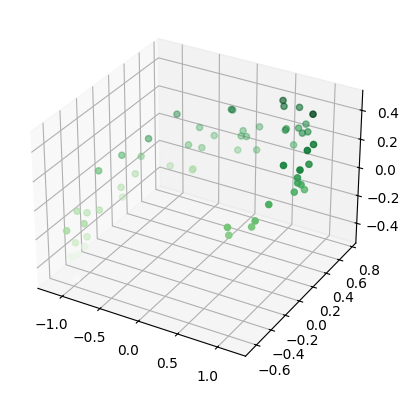

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,0], X_train[:, 1], X_train[:, 2], c=X_train[:, 2], cmap='Greens')

In [4]:
encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape=[3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape=[2]))
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1.5))

autoencoder.fit(X_train, X_train, epochs=30)

2024-04-01 09:40:32.546903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 09:40:32.767361: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
2/2 [==============================] - 0s 6ms/step - loss: 0.2607
Epoch 2/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2561
Epoch 3/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2516
Epoch 4/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2474
Epoch 5/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2434
Epoch 6/30
2/2 [==============================] - 0s 4ms/step - loss: 0.2393
Epoch 7/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2355
Epoch 8/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2316
Epoch 9/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2279
Epoch 10/30
2/2 [==============================] - 0s 4ms/step - loss: 0.2244
Epoch 11/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2210
Epoch 12/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2176
Epoch 13/30
2/2 [==============================] - 0s 3ms/step - loss: 0.

In [5]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 3ms/step


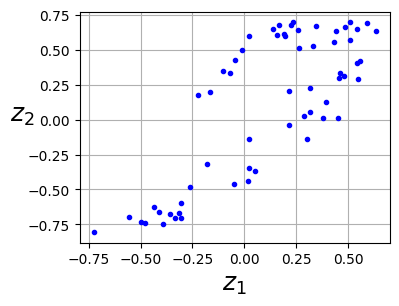

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2)

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_val = X_val.astype(np.float32) / 255

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
stacked_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28,28]),
                                          keras.layers.Dense(100, activation='selu'),
                                          keras.layers.Dense(30, activation='selu')])

stacked_decoder = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                          keras.layers.Dense(784, activation='sigmoid'),
                                          keras.layers.Reshape([28, 28])])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [10]:
history = stacked_ae.fit(X_train, X_train, epochs=30, validation_data=(X_val, X_val))

Epoch 1/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3428 - rounded_accuracy: 0.8826 - val_loss: 0.3143 - val_rounded_accuracy: 0.9042
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3081 - rounded_accuracy: 0.9128 - val_loss: 0.3035 - val_rounded_accuracy: 0.9198
Epoch 3/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3014 - rounded_accuracy: 0.9187 - val_loss: 0.2996 - val_rounded_accuracy: 0.9229
Epoch 4/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2978 - rounded_accuracy: 0.9217 - val_loss: 0.2956 - val_rounded_accuracy: 0.9238
Epoch 5/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2953 - rounded_accuracy: 0.9240 - val_loss: 0.3021 - val_rounded_accuracy: 0.9099
Epoch 6/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2935 - rounded_accuracy: 0.9256 - val_loss: 0.2921 - val_rounded_accuracy: 0.9266
Epoch 7/30
1500/1500 [==================

In [11]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

In [12]:
def show_reconstructions(model, images=X_val, n_images=5):
    true_images = images[:n_images]
    recon_images = model.predict(true_images)

    figure = plt.figure(figsize=(8.6, 6))
    for i in range(n_images):
        figure.add_subplot(2, n_images, i + 1)
        plot_image(true_images[i])
        figure.add_subplot(2, n_images, i + 1 + n_images)
        plot_image(recon_images[i])

In [13]:
# show_reconstructions(stacked_ae)

In [14]:
from sklearn.manifold import TSNE

X_val_compressed = stacked_encoder.predict(X_val)
tsne = TSNE()
X_val_2D = tsne.fit_transform(X_val_compressed)

375/375 [==============================] - 1s 1ms/step


In [15]:
# plt.scatter(X_val_2D[:,0], X_val_2D[:, 1], c=y_val, s=10, cmap='tab10')

### Tying Weights

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', shape=[self.dense.input_shape[-1]], initializer="zeros")        
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)
        

In [17]:
dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_val, X_val))

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3316 - rounded_accuracy: 0.8912 - val_loss: 0.3046 - val_rounded_accuracy: 0.9129
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2997 - rounded_accuracy: 0.9197 - val_loss: 0.2952 - val_rounded_accuracy: 0.9242
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2939 - rounded_accuracy: 0.9253 - val_loss: 0.2922 - val_rounded_accuracy: 0.9297
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2904 - rounded_accuracy: 0.9286 - val_loss: 0.2883 - val_rounded_accuracy: 0.9298
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2881 - rounded_accuracy: 0.9307 - val_loss: 0.2862 - val_rounded_accuracy: 0.9331
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2865 - rounded_accuracy: 0.9322 - val_loss: 0.2861 - val_rounded_accuracy: 0.9307
Epoch 7/10
1500/1500 [==================

In [18]:
# show_reconstructions(tied_ae)
# plt.show()

### CNN Autoencoder

In [19]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='selu', input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

In [20]:
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

In [21]:
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=[X_val, X_val])

Epoch 1/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3052 - rounded_accuracy: 0.9158 - val_loss: 0.2818 - val_rounded_accuracy: 0.9336
Epoch 2/5
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2777 - rounded_accuracy: 0.9392 - val_loss: 0.2740 - val_rounded_accuracy: 0.9443
Epoch 3/5
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2726 - rounded_accuracy: 0.9443 - val_loss: 0.2699 - val_rounded_accuracy: 0.9474
Epoch 4/5
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2697 - rounded_accuracy: 0.9474 - val_loss: 0.2675 - val_rounded_accuracy: 0.9507
Epoch 5/5
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2678 - rounded_accuracy: 0.9494 - val_loss: 0.2669 - val_rounded_accuracy: 0.9511


1/1 [==============================] - 0s 92ms/step


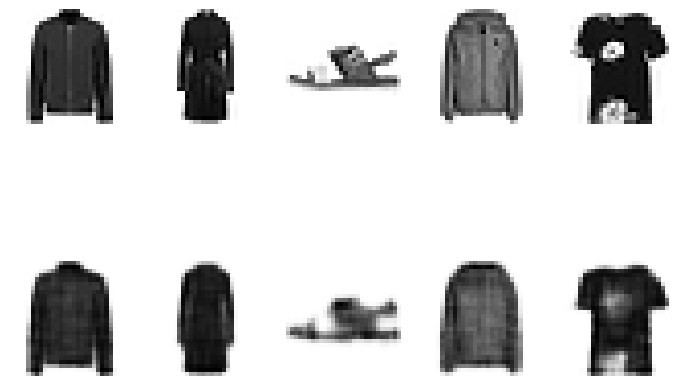

In [22]:
show_reconstructions(conv_ae)

In [23]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

### RNN Autoencoder

In [24]:
rnn_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28,28]),
    keras.layers.LSTM(30)
])
rnn_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])

In [25]:
rnn_ae = keras.models.Sequential([rnn_encoder, rnn_decoder])


### Denoising Autoencoder

In [26]:
denoise_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
denoise_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'), 
    keras.layers.Reshape([28,28])
])

In [27]:
denoise_ae = keras.models.Sequential([denoise_encoder, denoise_decoder])
denoise_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
history = denoise_ae.fit(X_train, X_train, epochs=10, validation_data=(X_val, X_val))

Epoch 1/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3596 - rounded_accuracy: 0.8677 - val_loss: 0.3208 - val_rounded_accuracy: 0.9046
Epoch 2/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3202 - rounded_accuracy: 0.9012 - val_loss: 0.3122 - val_rounded_accuracy: 0.9088
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3145 - rounded_accuracy: 0.9060 - val_loss: 0.3078 - val_rounded_accuracy: 0.9142
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3107 - rounded_accuracy: 0.9091 - val_loss: 0.3041 - val_rounded_accuracy: 0.9165
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3080 - rounded_accuracy: 0.9112 - val_loss: 0.3017 - val_rounded_accuracy: 0.9186
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3060 - rounded_accuracy: 0.9128 - val_loss: 0.3000 - val_rounded_accuracy: 0.9190
Epoch 7/10
1500/1500 [==================

In [28]:
# show_reconstructions(denoise_ae)

(-0.5, 27.5, 27.5, -0.5)

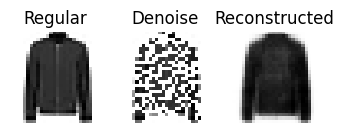

In [29]:
dropout = keras.layers.Dropout(0.5)
figure = plt.figure(figsize=[4,3])
figure.add_subplot(1,3,1)
plt.imshow(X_val[0], cmap='binary')
plt.title('Regular')
plt.axis('off')
figure.add_subplot(1,3,2)
plt.imshow(dropout(X_val[0], training=True), cmap='binary')
plt.title('Denoise')
plt.axis('off')
figure.add_subplot(1,3,3)
plt.imshow(denoise_ae(dropout(X_val))[0], cmap='binary')
plt.title('Reconstructed')
plt.axis('off')

### Sparse Autoencoder

In [30]:
sparse_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid', activity_regularizer=keras.regularizers.l1(1e-3))
])

sparse_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

In [31]:
sparse_ae = keras.models.Sequential([sparse_encoder, sparse_decoder])
sparse_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
history = sparse_ae.fit(X_train, X_train, epochs=20, validation_data=(X_val, X_val))

Epoch 1/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4383 - rounded_accuracy: 0.8081 - val_loss: 0.3809 - val_rounded_accuracy: 0.8586
Epoch 2/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3728 - rounded_accuracy: 0.8663 - val_loss: 0.3659 - val_rounded_accuracy: 0.8737
Epoch 3/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3617 - rounded_accuracy: 0.8745 - val_loss: 0.3563 - val_rounded_accuracy: 0.8768
Epoch 4/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3507 - rounded_accuracy: 0.8824 - val_loss: 0.3453 - val_rounded_accuracy: 0.8878
Epoch 5/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3420 - rounded_accuracy: 0.8885 - val_loss: 0.3388 - val_rounded_accuracy: 0.8919
Epoch 6/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3364 - rounded_accuracy: 0.8925 - val_loss: 0.3340 - val_rounded_accuracy: 0.8930
Epoch 7/20
1500/1500 [==================

### Variational Autoencoders

In [71]:
import keras.backend as K

In [72]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_sigma = inputs
        epsilon = keras.backend.random_normal(tf.shape(z_sigma))
        return z_mean + tf.math.exp(z_sigma / 2) * epsilon

In [76]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])


# KL_divergence=−0.5×∑i=1N​(1+log(σi2​)−μi2​−σi2​)
# Because we interpret the output as the logarithm of the variance.
# in the kl_div below we exponent the log of variance to get clean variance
kl_divergence = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),axis=-1)
variational_ae.add_loss(keras.backend.mean(kl_divergence) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_val, X_val))


Epoch 1/25
375/375 [==============================] - 4s 9ms/step - loss: 0.4218 - rounded_accuracy: 0.8285 - val_loss: 0.3690 - val_rounded_accuracy: 0.8813
Epoch 2/25
375/375 [==============================] - 3s 8ms/step - loss: 0.3593 - rounded_accuracy: 0.8859 - val_loss: 0.3485 - val_rounded_accuracy: 0.8991
Epoch 3/25
375/375 [==============================] - 3s 8ms/step - loss: 0.3468 - rounded_accuracy: 0.8947 - val_loss: 0.3446 - val_rounded_accuracy: 0.8908
Epoch 4/25
375/375 [==============================] - 3s 8ms/step - loss: 0.3400 - rounded_accuracy: 0.8997 - val_loss: 0.3369 - val_rounded_accuracy: 0.9048
Epoch 5/25
375/375 [==============================] - 3s 8ms/step - loss: 0.3353 - rounded_accuracy: 0.9032 - val_loss: 0.3332 - val_rounded_accuracy: 0.9044
Epoch 6/25
375/375 [==============================] - 3s 8ms/step - loss: 0.3317 - rounded_accuracy: 0.9057 - val_loss: 0.3308 - val_rounded_accuracy: 0.9060
Epoch 7/25
375/375 [==============================] 

In [79]:
tf.random.normal(shape=[12, 10])

<tf.Tensor: shape=(12, 10), dtype=float32, numpy=
array([[-1.0733447 ,  0.32419926,  1.1476887 ,  1.2129301 ,  1.0743219 ,
        -0.35113394,  1.1499542 ,  0.03601112, -0.5089264 ,  1.0171323 ],
       [-0.04627132, -0.8545577 ,  0.5688811 ,  0.0610069 , -0.9976953 ,
         1.1604035 , -0.09311827, -0.76888704,  0.7250433 , -0.04074414],
       [-0.09332724, -0.3835917 , -2.239516  ,  0.39910224, -1.119083  ,
         1.242472  ,  0.04075911,  1.4495783 ,  1.0095693 , -0.6411432 ],
       [-0.25196987, -0.3755101 ,  0.11307679,  0.18841872, -1.0031862 ,
        -0.5460064 , -0.43361568, -0.99778664, -0.45980075, -1.5180881 ],
       [-0.04089227, -1.0554836 ,  0.39958712,  0.43413964, -0.47269833,
         0.28142348,  0.58040065, -0.868907  , -0.9946907 ,  0.24215478],
       [ 0.782916  , -0.42721096, -0.4522695 , -1.8608575 , -0.5739376 ,
        -0.5681454 , -1.4418663 ,  1.4266815 ,  0.7962692 ,  0.2833088 ],
       [ 1.124619  ,  0.9885353 , -0.9634498 , -0.19654171,  1.56200